In [23]:
import pandas as pd
import numpy as np
from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
import pdvega  # adds vgplot attribute to pandas
from datetime import datetime
import matplotlib.dates as mdates
import scipy


class Solar_Gains(object):
    # Later add dates
    """ Calculate and plot the solar energy and power gained by a building through its windows
    
    Keyword arguments:
        location -- region that that house is in. Used to create the path from which sun angle data is imported.    
        windows -- dictionary. Key is the orientation(string 'N', 'NNE' etc.). Value is a tuple of 
            (the window area (m2), the window solar heat gain coefficient).
        min_alt -- an integer or float. The solar altitude below which the sun is considered to have no heating effect.
        summertime_correction -- (default True). If True, removes summertime timezone shift from data.
        half_hour_correction -- (default True). If True, shifts datetime half an hour back. To be used when intensity data
            is actually the average intensity for the previuos hour.
    """

    def __init__(self, location, windows, min_alt, meteo_path, summertime_correction=True, half_hour_correction=True):
        """Calls functions to import and calculate all intensities, weights, powers and energies for the building"""

        self.windows = self.format_windows(windows)
        min_alt = np.deg2rad(min_alt)

        #Import data
        (intensities, hourly_intensities) = self.import_intensities(meteo_path, summertime_correction, half_hour_correction)
        (angles, angles_1_min) =  self.import_angles(location, intensities['day_of_year']) 

        #Calculate weightings and intensities
        (weights, weights_1_min) = self.horizontal_to_vertical(min_alt, angles, angles_1_min, intensities)
        intensities = self.sun_on_vertical(intensities, weights)
        #for 5 minute data
        self.angles = self.azimuthal_angles(self.windows, angles)
        weights = self.azim_weightings(self.windows, weights, self.angles)
        #for 1 minute data
        self.angles_1_min = self.azimuthal_angles(self.windows, angles_1_min) 
        weights_1_min = self.azim_weightings(self.windows, weights_1_min, self.angles_1_min)
        
        (self.intensities, self.weights, self.weights_1_min) = self.sun_on_walls(self.windows, intensities, weights, weights_1_min)

        #Calculate powers and energies
        self.powers = self.power_through_windows(self.windows,self.intensities)
        self.energy = self.daily_energy_gain(self.powers)
        
        # Define labels and formatting for later plots
        self.plot_labels = {'weights': {'ylab':'Weighting', 'title':'Weighting %s' % location },
                            'angles': {'ylab':'Angle (degrees)' , 'title':'Sun angle %s' % location },
                            'angles_1_min': {'ylab':'Angle (degrees)' , 'title':'Sun angle %s' % location },
                            'intensities': {'ylab':'Intensity ($W/m^2$)', 'title':'Sun intensity %s' % location },
                            'powers': {'ylab':'Power through window (kW)', 'title':'Solar power transmitted through windows' },
                            'energy': {'ylab':'Energy gain through window (kWh)', 'title':'Solar energy gained through windows'}
                            }

        self.titlefontsize = 18
        self.axislabelfontsize = 16
        self.legendfontsize = 14

    def format_windows(self, windows):
        """ Translate orientation label strings into angles from South clockwise to the face. Save colors to plot"""
        
        orientation_angles = {
                    'N': (12/16*(2*np.pi), '#d62728'),
                    'NNE': (13/16*(2*np.pi),'rebeccapurple'),
                    'NE': (14/16*(2*np.pi),'darkgreen'),
                    'ENE': (15/16*(2*np.pi), 'black'),
                    'E': (0*(2*np.pi),'#2ca02c'),
                    'ESE': (1/16*(2*np.pi),'magenta'),
                    'SE': (2/16*(2*np.pi),'midnightblue'),
                    'SSE': (3/16*(2*np.pi),'grey'),
                    'S': (4/16*(2*np.pi),'#ff7f0e'),
                    'SSW': (5/16*(2*np.pi),'dodgerblue'),
                    'SW': (6/16*(2*np.pi),'cyan'),
                    'WSW': (7/16*(2*np.pi),'darkred'),
                    'W': (8/16*(2*np.pi),'#1f77b4'),
                    'WNW': (9/16*(2*np.pi),'crimson'),
                    'NW': (10/16*(2*np.pi),'lime'),
                    'NNW': (11/16*(2*np.pi),'red'),
                    }

        deltas = [0]*len(windows)
        areas = [0]*len(windows)
        colors = [0]*len(windows)
        SHGCs = [0]*len(windows)
        
        #make lists of all the variables we want and look up the orientation value for each face (hence why not dict to df immediately)
        for i,  (orientation, (area,SHGC)) in enumerate(windows.items()):
            areas[i] = area
            SHGCs[i] = SHGC
            # Look up the numeric orientation value for each face.
            (deltas[i], colors[i]) = orientation_angles.get(orientation, 1000)
            if deltas[i] == 1000:
                raise AttributeError("The first column of the window matrix must be either 'N','NNE','NE','ENE','E','ESE','SE', 'SSE','S','SSW','SW','WSW','W','WNW','NW','NNW'")
          
        #Make a windows data frame with labels, orientation angles, areas and SHGC's
        data = {'label': list(windows.keys()), 'deltas': deltas, 'area_m2':areas, 'SHGC':SHGCs, 'color':colors}
        windows_df = pd.DataFrame(data = data)
        windows_df = windows_df.set_index('label')
        return(windows_df)


    def import_intensities(self, path, summertime_correction, half_hour_correction):
        """ Import the solar intensity data from a file in the same folder as this file.
        
            You can get this data from: https://www.simeb.ca:8443/index_fr.jsp. The file should include
            the local date, local time, temperature, humiditiy, atmpospheric pressure and sun intensity.
            """
            
        df_i_h = pd.read_csv(path,
                       sep = '\t',
                       header =0,
                       names = ['date', 'time', 'sun_on_horizontal'],
                       usecols = [0,1,5], #currently set up such that the weather file columns are:
                                          # 0. Local date, 1. Local time, 2. Temperature, 3. Humiditity
                                          # 4. Atmospheric pressure, #5. sun intensity.
                       parse_dates = [[0,1]],
                       dayfirst = 'True', #this is needed to stop it thinking the dates are american formatted
                       index_col = 0,
                       skiprows = 1)
        
        #save start and end dates that you can use it for the sun angles
        #this relies on the data being for the same year
        self.angles_index_start = df_i_h.index [0]
        self.angles_index_end = df_i_h.index [-1]
        
        if summertime_correction == True: #an if only so I can show the error when this isn't on
            #Change index so it doesn't change to summer time
            #Additionaly assume that the solar intensity data is actually the average of the hour before.
            #The appropriate index is thus the middle of the hour before. 
            #As such take of half an hour of the indices 
            if half_hour_correction == True:
                df_i_h.index = pd.date_range(start = df_i_h.index[0] - pd.Timedelta(minutes=30), end = df_i_h.index[-1] - pd.Timedelta(minutes=30), freq= '1H')
            else:
                #just left in here to demonstrate issue
                df_i_h.index = pd.date_range(start = df_i_h.index[0], end = df_i_h.index[-1], freq= '1H')
                
        #interpolate data so it's every 5 minutes to allow multiplication by higher frequency weighting data.
        df_i_m = df_i_h.resample('5Min').sum() #resample the hourly data every minute
        df_i_m = df_i_m.interpolate(method= 'polynomial', order = 1) #linear fit between the hour data points

        # Add an integer time column for later functions that can't manage the datetime index
        days = pd.to_numeric(df_i_m.index - df_i_m.index[0])/(1000000000*3600*24)
        df_i_m.insert(0, 'day_of_year',days) 
        
        return(df_i_m, df_i_h)
        
    def import_angles(self, location, intensities_index):
        ''' Import the solar angles data from a file in the same folder as this file.
        
            You can get this data from http://susdesign.com/sunposition/.
            The sun angles filename must be: 'location_sun_angles.csv' (eg 'montreal_sun_angles.csv').
            The format of the sun angle file must be as follows: column 0 - date, column 1 - time,
            column 3 - altitude, column 4 - azimuth. '''
        
        def import_angles_sub(path):
        
            df_a = pd.read_csv(path,
                sep = '\t',
                header = 0,
                names = ['date', 'time','alt', 'azim'],
                usecols = [0,1,2,3],
                parse_dates = [[0,1]],
                index_col = 0)

            # Keep some in degrees for plotting
            df_a.insert(0, 'sun altitude', df_a['alt'])
            df_a.insert(1,'azim_degrees', df_a['azim'])

            # Convert to radians for calculations:
            df_a[['alt', 'azim']] = df_a[['alt', 'azim']].apply(np.deg2rad)

            # Convert all azimuthal angles so between 0 and 2pi as confusing if a mixture
            mask = df_a['azim'] < 0
            df_a.loc[mask, 'azim'] = df_a.loc[mask, 'azim'] + 2*np.pi
            return(df_a)
    
        #Import 5 minute angles for use with intensities
        
        path_5 = '%s_sun_angles_5_mins.csv'%location
        angles = import_angles_sub(path_5)

        # Need to change date and time format so it is the same as the meteo formatting.
        angles.index = pd.date_range(start=self.angles_index_start, end=self.angles_index_end, freq= '5Min')
        # Add an integer time column for later functions that can't manage the datetime index
        angles.insert(0, 'day_of_year',intensities_index)
        
        #Import 1 minute angles for use on own - just here to show neater weighting plots
        path_1 = '%s_sun_angles_1_min.csv'%location
        angles_1_min = import_angles_sub(path_1)
        
        return(angles, angles_1_min)

    def horizontal_to_vertical(self, min_alt, angles, angles_1_min, intensities):
        """Calculate conversion factors from sun intensity on horizontal to sun intensity on vertical surface facing the sun."""
        
        def horizontal_to_vertical_sub(min_alt, df):
            
            w = 1/np.tan(df['alt']) 
            # Weighting of 0 if the sun is below the horizon
            w[df['alt'] < min_alt] = 0
            return(w)

        #for 5 minute data
        
        weights = pd.DataFrame()
        weights['h_to_v'] = horizontal_to_vertical_sub(min_alt,angles)
        # Add an integer time columnfor later functions that can't manage the datetime index
        weights.insert(0, 'day_of_year',intensities['day_of_year'])
        
        #for 1 minute data - calculated just to plot nicer weights plots - never used to calculate intesnities
        
        weights_1_min = pd.DataFrame()
        weights_1_min['h_to_v'] = horizontal_to_vertical_sub(min_alt,angles_1_min)
        
        return(weights,weights_1_min)

    def sun_on_vertical(self, intensities, weights):
        """Convert sun intensity on horizontal data to sun intensity on vertical surface facing the sun."""

        #Apply weightings to sun intensities to get radiation on a vertical surface which is yawed at the sun.
        intensities['sun_on_v'] = intensities['sun_on_horizontal']* weights['h_to_v']
        return(intensities)

        
    def azimuthal_angles(self, windows, angles):
        """ Calculate the angle clockwise from the ray of sunlight to the walls"""
        
        for i, val in enumerate(windows['deltas'] ):
            angles['azim_%s'%windows.index[i]] = val - angles['azim']
        return(angles)

        
    def azim_weightings(self, windows, weights, angles):
        """ Calculate conversion factors from sun intensity on vertical facing the sun to sun intensity on each wall. """

        # Function used in loop to set intensities to 0 when wall is shaded
        def not_xray(x):
            if x < 0:
                x = 0

            return x

        for lab in windows.index:    

            weights['v_to_%s_face'%lab] = np.sin(angles['azim_%s'%lab])

            # Need to get rid of values greater than 180 degrees as that is on the back of the wall
            weights['v_to_%s_face'%lab] = weights['v_to_%s_face'%lab].apply(not_xray)

        return(weights)
            

    def sun_on_walls(self, windows, intensities, weights, weights_1_min):
        """  Calculate the sun intensity on each wall"""

        for lab in windows.index:
            intensities['sun_on_%s_face'%lab] = intensities['sun_on_v'] * weights['v_to_%s_face'%lab]

            # Multiply the azimuthal and altitude weightings to get the weighting from horizontal to vertical
            # on each face. These values aren't used but are calculated for interest.
            #for 5 minutes
            weights['h_to_%s_face'%lab] = weights['v_to_%s_face'%lab] * weights['h_to_v']
            #for 1 minutes
            weights_1_min['h_to_%s_face'%lab] = weights_1_min['v_to_%s_face'%lab] * weights_1_min['h_to_v']
            
        return(intensities, weights, weights_1_min)
        
    def power_through_windows(self, windows, intensities):
        """Calculate the power (in kW) passing through the windows on each face """

        powers = pd.DataFrame()

        # Multiply the incident sun intensity by the area and solar heat gain coefficient of the window
        # Divide by 1000 to put into kW
        for lab in windows.index:
            powers['windows_%s_face'%lab] = intensities['sun_on_%s_face'%lab] * windows['area_m2'][lab] * windows['SHGC'][lab]/1000

        powers['all_windows'] = powers.sum(axis=1)

        # Add an integer time columnfor later functions that can't manage the datetime index
        powers.insert(0, 'day_of_year', self.intensities['day_of_year'])
        
        return(powers)

    def daily_energy_gain(self, powers):
        """ Integrate the energy gain (in kWh) through windows on each face each day"""

        # Sum the powers for each day to get the daily energy gain. Don't take the hours of the day column
        reduced_powers = powers.iloc[:,1:] * 5/60
        energy = reduced_powers.resample('D').sum()

        # Add an integer time column for later functions that can't manage the datetime index
        energy.insert(0, 'day_of_year', list(range(1, len(energy.index)+1)))
        
        return(energy)

    def solar_plot(self, df_name, variables, start_date = '2015-01-01', end_date = '2015-12-31', title = None,ymax = None, colors = ['r','b','g','y']):
        """  Plot the variables for the named timeframe
        
        Keyword argument:
            variables -- list of variables you would like to plot
            df_name --  a string. Name of the data frame the variables are in. Can only be
                "weight', "angles", "intensities", "powers" or "energy"
            start_date --  first date to plot. It should be in the format `2015-01-01`
            end_date -- last date to plot. It should in in the format `2015-12-31`
        """

        df_nsp = getattr(self, df_name)
        ylab = self.plot_labels[df_name]['ylab']
        if title == None:
            title = self.plot_labels[df_name]['title']
        
        colors = self.windows.get('color')
        df_nsp[variables].loc[start_date:end_date].plot(figsize = (20,6), color = colors)

        plt.xlabel('Date', fontsize = self.axislabelfontsize)
        plt.ylabel(ylab, fontsize = self.axislabelfontsize)
        plt.ylim(ymax = ymax)
        plt.title(title, fontsize = self.titlefontsize)
        plt.legend(fontsize = self.legendfontsize)
        
        plt.show()

    def solar_plot_vega(self, df_name, variables):
        ''' Plot the variables named in'variables' from the dataframe 'df_name' in an interactive plot.
        
        Keyword arguments:
            variables -- list of variables you would like to plot
            df_name --  a string. Name of the data frame the variables are in. Can only be
                "weight', "angles", "intensities", "powers" or "energy"
        '''
        
        df_spv = getattr(self, df_name)
        plot_nsp = df_spv.vgplot(x = 'day_of_year', y = variables) #pdvega Can't handle date time objects so have to use days of the year instead 
        plot_nsp.display()


    def seasons_comparison_plot(self, df_name):
        """Plots the attribute (not energy) for the summer soltice, the winter soltice and the spring equinox. """

        #Select appropriate columns depending on seleted data frame
        header_indices = {'angles': {'header_index_start': 1, 'header_index_end': 2},
                          'intensities': {'header_index_start': 3, 'header_index_end': 7},
                          'weights': {'header_index_start': 6, 'header_index_end': 10},
                          'powers': {'header_index_start': 1, 'header_index_end': 5},
                            }
        istart = header_indices[df_name]['header_index_start']
        iend = header_indices[df_name]['header_index_end']
        colors = self.windows.get('color')

        #select variables to plot
        df_scp = getattr(self, df_name)
        variables = list(df_scp)[istart:iend]

        #Set up dates and titles of days to plot
        key_days = {'Spring equinox':{'start_date': '2015-03-21','end_date': '2015-03-21', 'm': 0},
                    'Summer soltice':{'start_date': '2015-06-21','end_date': '2015-06-21', 'm': 1},
                    'Winter soltice':{'start_date': '2015-12-21','end_date': '2015-12-21', 'm': 2},
                   }
        
    
        
        #set up plot
        fig, axes = plt.subplots(nrows=1, ncols=3, sharey = True)

        #plot
        for day, item in key_days.items():
            df_scp[variables].loc[item['start_date']:item['end_date']].plot(ax = axes[item['m']], title = day, figsize = (18,5), legend = False, color = colors)


        #Format
        ylab = self.plot_labels[df_name]['ylab']
        axes[0].set_ylabel(ylab)
        axes[2].legend()
        
        plt.show()

    def energy_comparison_plot(self):
        """Plots energy gain in March, June and December. """

        #select variables to plot
        df_ecp = self.energy
        variables = list(df_ecp)[1:5]
        
        #Set up dates and titles of days to plot
        key_months = {'March':{'start_date': '2015-03-01','end_date': '2015-03-31', 'm': 0 },
                    'June':{'start_date': '2015-06-01','end_date': '2015-06-30', 'm': 1},
                    'December':{'start_date': '2015-12-01','end_date': '2015-12-31', 'm': 2},
                   }

        #set up plot
        fig, axes = plt.subplots(nrows=1, ncols=3, sharey = True)

        for month, item in key_months.items():
            df_ecp[variables].loc[item['start_date']:item['end_date']].plot(ax = axes[item['m']], title = month, figsize = (20,8), legend = False)

        #Format
        ylab = 'Energy gained though the windows during the day (kWh)'
        axes[0].set_ylabel(ylab, fontsize = self.axislabelfontsize)
        axes[2].legend(fontsize = self.legendfontsize)
        plt.show()






In [24]:
location = 'Montreal'
N_windows = {'W': (8, 0.4), 'S': (8, 0.4), 'E': (8, 0.4), 'N': (8, 0.4)} 
no_min_alt = 0
year = 2015
path_unmodified = 'montreal_meteo_%s_unmodified.csv'%year

In [25]:
No_Min_Alt = Solar_Gains(location, N_windows, no_min_alt, path_unmodified )

 # How much does the sun heat your house? #

## Motivation ##

Here at Marmott Energies we design ground source heating systems for people’s homes. These systems consist of a ground source heat pump and a ‘ground loop’. A ground loop is simply a loop of pipe that goes deep into the ground. The water in the pipe collects heat from the ground and transfers that heat to the heat pump. The heat pump uses a small amount of electricity to increase the temperature of that heat. It then transfers the heat into your house.

The first step in installing a geothermal system is deciding how big the heat pump and the ground loop should be. In order to do this, we have to calculate how much heating and cooling a house is going to need. It is particularly important that we do these calculations accurately with geothermal because the capital cost of the installation is the major part of the total heating cost. This is not the case for conventional heating systems. If you are installing a gas or oil furnace, the furnace itself is not expensive over its lifetime. The major cost of heating is the gas or fuel oil which that furnace burns. Installers can simply put in a furnace with excess capacity and it won't cost the customers much extra money. They will still burn the same amount of gas or oil they would have done in a smaller furnace. With geothermal, in contrast, getting the size of the system wrong has big financial implications. 

Marmott's raison d'etre is to make geothermal more affordable and hence more accessible. To do that we need to ensure that geothermal provides great value for money, and to do that we have to size systems correctly. We therefore need to be able to make accurate estimates of the heating and cooling requirements of a house.

## Calculating solar gains ##

How much heating and cooling a house requires depends on:

- the weather outside (temperature, humidity, wind and sunshine)
- what your house is made of and how well it is sealed
- what temperature and humidity you want it to be inside
- what other things are making heat within the house (ovens, fridges, people…)

One of the most challenging aspects of the calculation is figuring out how much the sun will heat up a house. Irrespective of the temperature outside, if the sun is shining on a window, your house will absorb some heat from that sunshine. Exactly how much heat will depend on the strength of the sunlight, how directly the sun is shining on the window, the size of the window and a property of the window itself called the solar heat gain coefficient. The solar heat gain coefficient of a window describes what proportion of the light hitting the glass gets through it. 

When we are looking at the solar gains of a building, there are two results we are interested in:

1. **The *power* being transmitted through the windows *(kW)* ** - relevant because our heating and cooling systems provide a certain power. If 2kW of sunlight is entering your house through the windows in winter then your heating can be turned down by 2kW. If 2kW of sunlight is entering your house throught the windows in summer however, then that is 2kW of extra power that your air conditioning system needs to remove.

2.  **The *energy* transmitted through the windows *(kWh)* ** - relevant because it is what we pay for. Energy is power times time. So if we have 2kW of sunshine coming through the window for an hour in winter, then we have gained 2kWh's of energy. That's 2kWh of energy that we don't need to pay for. 

In what follows, I'll describe how we calculate the solar power being transmitted through the windows, and the  overall solar energy gained through the windows. Once I've done the calculations, I'll use the resulting model to explore how you can best design a house to exploit these solar gains and so minimise the heating and cooling requirements of the house. This is called passive solar design. Like geothermal, it is a great way to heat buildings without emitting greenhouse gases. 

### The data ###

#### Solar intensity ####
Hydro-Quebec runs a website called [‘SIMEB’](https://www.simeb.ca:8443/index_fr.jsp) which provides hourly weather data for many towns in Quebec. This website is invaluable to us because it gives us the data we need to calculate the hourly heat loss or gain of a house. One of the pieces of information it provides is the intensity of solar radiation falling on a horizontal surface. The data for Montreal is plotted below.   


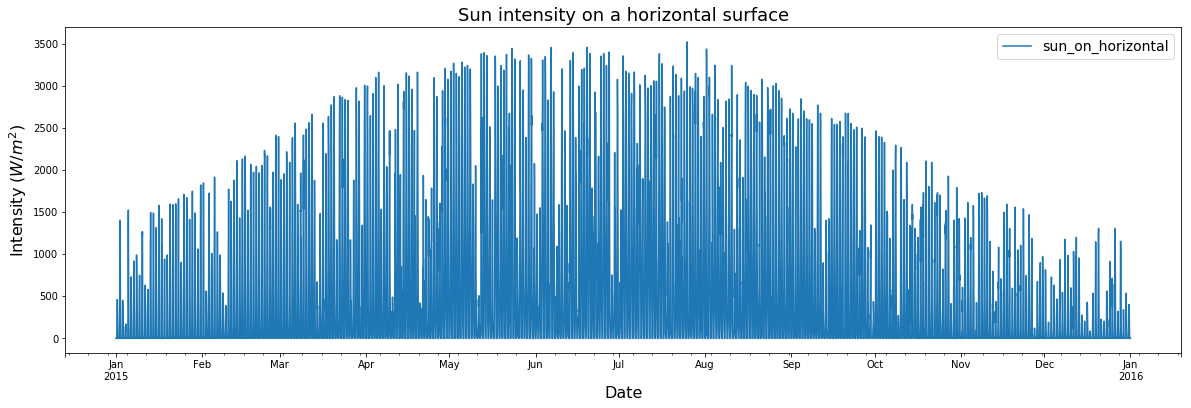

In [26]:
No_Min_Alt.solar_plot('intensities', ['sun_on_horizontal'], title = 'Sun intensity on a horizontal surface')

In the above plot we see that the intensity of solar radiation on a horizontal surface is high in the summer and low in the winter. That's because in the summer the sun is higher in the sky and so shines more directly onto the ground. The intensity of the solar radiation also jumps around a bit. It's sometimes cloudy and so the clouds block the sun from hitting the floor. The plot looks almost solid at this scale because every night the radiation hitting the ground falls to zero. To better show the detail I have plotted a 'zoomed in' version below. 

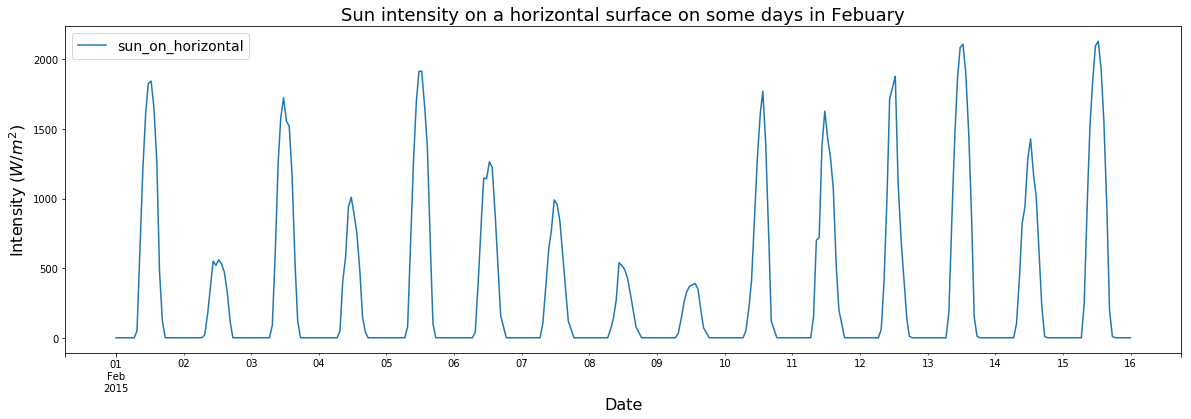

In [27]:
No_Min_Alt.solar_plot('intensities', ['sun_on_horizontal'],
                      start_date = '2015-02-01', end_date = '2015-02-15',
                      title = 'Sun intensity on a horizontal surface on some days in Febuary')

Ok, so we have data for the intensity of sunlight falling on a horizontal surface. What we want to calculate is the amount of solar power passing through the windows. To get there we first need to calculate the sun intensity falling on the windows. Windows tend to be vertical, not horizontal. They also have a certain orientation depending on which face of the building they are on. The sun will fall on different sides of the building at different times of day. In order to go from intensity of sunlight falling on the horizontal to the intensity of sunlight falling on windows, we are going to need to know more about the position on the sun.


#### Solar geometry ####

<img src="solar_geometry_big.png" alt="solar_geometry" style="width: 700px;"/>

There are two solar angles that determine the intensity of the sunlight falling on a particular surface. The first the solar altitude angle, $\theta$. The solar altitude is the angle between the sun's rays and a horizontal surface. It's how much you need to crane your neck to look up at the sun. If $\theta$ is big, you have to crane your neck a lot. If $\theta$ is small, the sun is in your eyes even when you are hardly looking up. The second angle is the azimuthal angle, $\phi$. The azimuthal angle describes where the sun is on a compass. It is defined clockwise from South. At the Equinox, when the sun rises it is in the East at $\phi$ = 270 degrees, at solar midday it is in the South at $\phi$ = 0 degrees, and when it sets it is in the West at $\phi$ = 90 degrees.

The [sun position tool](http://www.susdesign.com/sunposition/) made by susdesign gives hourly solar altitude and azimuthal angles for a given location. The altitude data for Montreal is plotted below. 

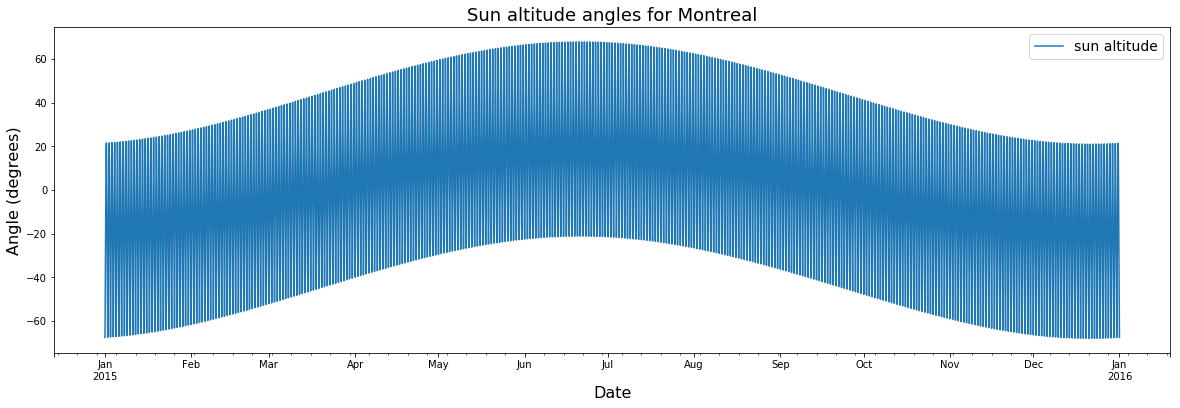

In [28]:
#plot altitude angles
No_Min_Alt.solar_plot('angles', ['sun altitude'], title = 'Sun altitude angles for Montreal')

 The sun altitude plot includes negative sun altitudes, that is to say, sun altitudes when the sun is below the horizon. Similarly to the solar intensities, this plot appears almost solid but that is just because the sun goes up and down every day. I've plotted the sun altitude at spring equinox, summer soltice and winter soltice below to give you a clearer picture of how the sun moves on a daily level.

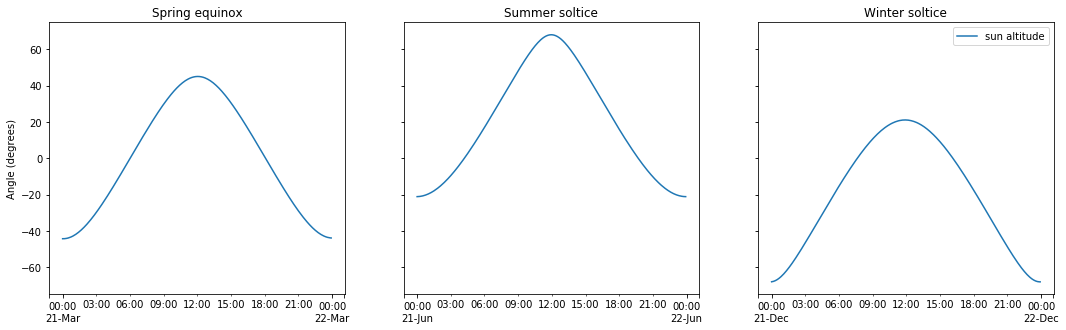

In [29]:
No_Min_Alt.seasons_comparison_plot('angles')

 ### The trigonometry ###
 
Now that we have data for the solar angles and the sun intensity on a horizontal surface, we need to combine them to calculate the heating effect of the sun on our building.

#### Sunflower windows ####

First we need to calculate the solar radiation you would get on a vertical surface facing the sun. So something that is vertical but rotates like a sunflower to get the most of the sun rays. We can calculate these intensities by using the horizontal intensities and some geometry. 

<img src="Sunflower_house.png" alt="Sunflower_house" style="width: 500px;"/>

In the picture above the intensity $I$ denotes the 'true intensity' of the sunlight. That's the intensity you would measure if you placed a surface at right angles to the sun's rays. $I_h$ denotes the intensity of the sunlight falling on a horizontal surface, and $I_v$ denotes the intensity of the sunlight falling on a vertical surface oriented towards the sun. The angle $\theta$ is the sun altitude. A bit of geometry shows us that the intensity of sun falling on a vertical surface oriented towards the sun ($I_v$), is equal to the intensity of sun falling on a horizontal surface ($I_h$) divided by $tan(\theta)$:


$I_v = I_h/tan(\theta)$

I want to avoid dividing by the tangent of zero (which equals zero) because that is equivalent to multiplying by infintity. I have therefore set a minimum altitude below which I don't consider the sun to have any warming effect. When the sun is very low, it is very likely that the sun is hitting trees or other buildings and so not hitting the walls of the house in question. I think a reasonable minimum altitude is 2°. When the sun is at 2 degrees, something 5 m high would have a 143m long shadow. It is therefore pretty likely that most windows will be in shadow at that point. The sun is between 0 and 2 degrees for about 15 minutes in the morning and 15 minutes in the evening. We are therefore not cutting off a very long period of time, even if a particular window happens not to be in the shade. 

In [30]:
min_alt = 2
N_house = Solar_Gains(location, N_windows, min_alt, path_unmodified)

#### Window orientation ####

We have now converted our data for sun intensity on a horizontal surface to sun intensity on a vertical surface which rotates to face the sun. However, windows do not rotate to face the sun. We therefore need to deal with the azimuthal angles. The angle which determines what proportion of the sun will fall on each wall is the angle between the sun's azimuthal direction and the face of the wall. These angles are marked with $\delta$ in the drawing below. When the angle $\delta$ is greater than 180 degrees, that face is in shade and so the intensity on that face = 0. When the angle $\delta$ is less than 180 degrees, some geometry shows us that the proportion of the sunlight which is shining directly onto a particular wall = the proportion of the sunlight falling on a vertical surface multiplied by the sine of $\delta$. So if we call the intensity of the sun falling on Wall 1 $I_1$, then:

$I_1 = I_v * sin(\delta_1)$.

<img src="wall_azimuths.png" alt="Drawing" style="width: 700px;"/>



### Putting it together ###

Combining the effect of the altitude and the azimuth gives us the conversion factor from the intensity on the horizontal surface to the intensity on a vertical wall with a particular orientation. I have plotted those conversion factors for North, South, East and West facing walls below.

In [31]:
orientations = ['W', 'S', 'E', 'N']
title = ['%s face'%lab for lab in orientations]
xticks = [N_house.weights_1_min.index.get_loc(timestamp) for timestamp in ['mar 21 00:00', 'jun 21 00:00', 'sep 21 00:00', 'dec 21 00:00']]    
variables_N_house = ['h_to_%s_face'%lab for lab in orientations]
colors = N_house.windows.get('color')

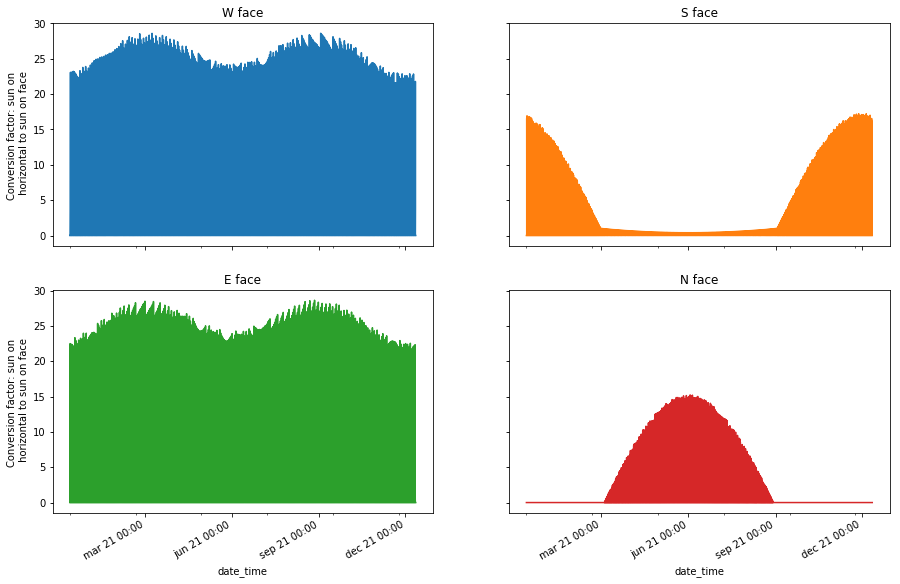

In [32]:
axes = N_house.weights_1_min[variables_N_house].plot(subplots = True,
                                               layout = (2,2),
                                               legend = False,
                                               sharey = True,
                                               title = title,
                                               xticks = xticks,
                                               sharex = True,
                                               figsize = (15,10),
                                               color = colors )

axes[0][0].set_ylabel('Conversion factor: sun on \n horizontal to sun on face')
axes[1][0].set_ylabel('Conversion factor: sun on \n horizontal to sun on face')
plt.show()

Wow!

Something super interesting is happening with the North and South faces. Sun only hits the North face in the summer. In the winter, the sun rises South of due East and sets South of due West. As such the sun is never above the horizon at times when it would otherwise fall on the North face. We therefore only get sun falling on North facing windows between the spring and the autumn equinoxes. On the South face, the low solar altitudes in winter mean the sun hits South facing windows quite directly. In summer however, the sun is high in the sky when it is in the South so it hits South facing windows at a very steep angle. As a result, very little light will pass through South facing windows in summer but a lot will in winter. That's a very attractive feature if we don't want to heat too much in the winter nor cool too much in the summer. We can further reduce the summer gains of South facing windows by adding a small roof overhang. As previously mentioned, the sun is very high in the sky in the summer when it is in the South. By adding a small roof overhang we can block any rays of sun that would otherwise have hit the windows. That small roof overhang won't block winter sun because the sun will be much lower in the sky in the winter.

The East and West plots are essentially the same. The little whiskery patterns on top of the plots are just due to the fact that the data isn't continuous. The weightings for East and West faces are slightly greater in spring and autumn than they are in winter and summer. In winter, the sun never shines directly onto the East and West faces because it rises South of due East and sets South of due West. In summer, the sun is quite high when it is shining onto the East and West faces and this reduces the weighting. In spring and autumn however, the sun is low in the sky when it is shining directly on the East and West faces and this gives a greater weighting. 

The plot below shows the weightings for a day in midsummer, a day in midwinter, and a day in spring. Looking at it on a daily level allows us to better understand when the sun shines on each face, and for how long.

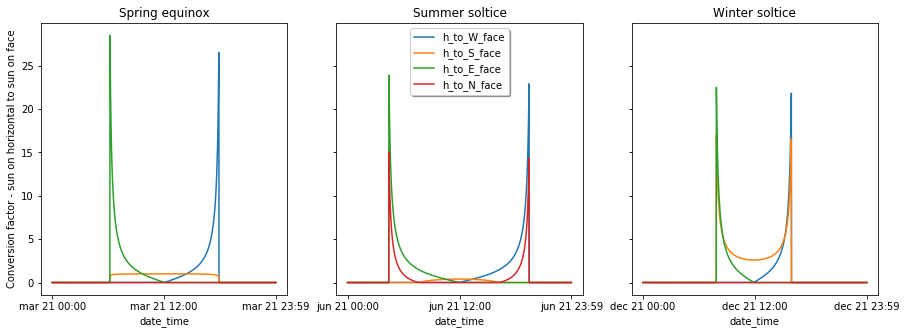

In [33]:
#Set up dates and titles of days to plot
key_days = {'Spring equinox':{'start_date': 'mar 21 00:00','end_date': 'mar 21 23:59', 'm': 0},
            'Summer soltice':{'start_date': 'jun 21 00:00','end_date': 'jun 21 23:59', 'm': 1},
            'Winter soltice':{'start_date': 'dec 21 00:00','end_date': 'dec 21 23:59', 'm': 2},
           }
xticks = [0, 12*60, 24*60-1]
#set up plot
fig, axes = plt.subplots(nrows=1, ncols=3, sharey = True)

#plot
for day, item in key_days.items():
    N_house.weights_1_min[['h_to_W_face', 'h_to_S_face', 'h_to_E_face', 'h_to_N_face']].loc[item['start_date']:item['end_date']].plot(ax = axes[item['m']], title = day, figsize = (15,5), legend = False, xticks = xticks)

#Format
axes[0].set_ylabel('Conversion factor - sun on horizontal to sun on face')
axes[1].legend(loc='upper center', shadow=True, fontsize='medium')
plt.show()

### Finishing off the analysis ###

We now multiply the 'solar intensity on the horizontal' data by the conversion factors calculated above to get data for 'solar intensity on each face of the house'. We then convert those intensities to the powers and energies that we are really interested in. To go from the intensity of the light falling on the wall (W/$m^2$) to the power of the sunlight hitting the windows, we multiply the intensity by the window areas. Only a fraction of the sunlight that hits the window will pass through it. The proportion of the sunlight that will pass through the window is defined by the solar heat gain coefficient. It is a property of the window itself. So to get the solar power passing through the windows, we just multiply the values for the power hitting the windows by the solar heat gain coefficient. 

The plot below shows the solar power passing through the windows on each side of a house which has 8 $m^2$ of windows on each face and a solar heat gain coefficent of 0.4. To give you some context on the size of a kW, a typical household kettle uses about 1.5kW, a large fridge uses about 0.8kW, an LED light bulb uses about 0.009kW.

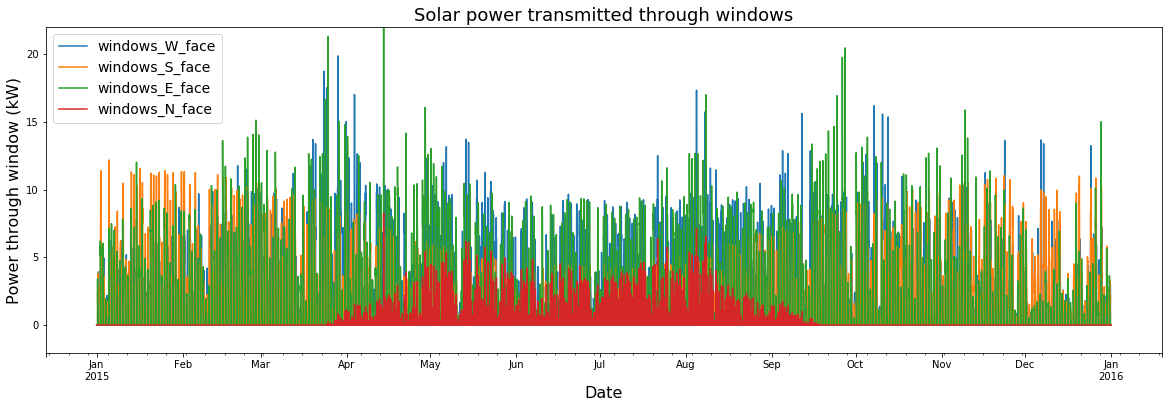

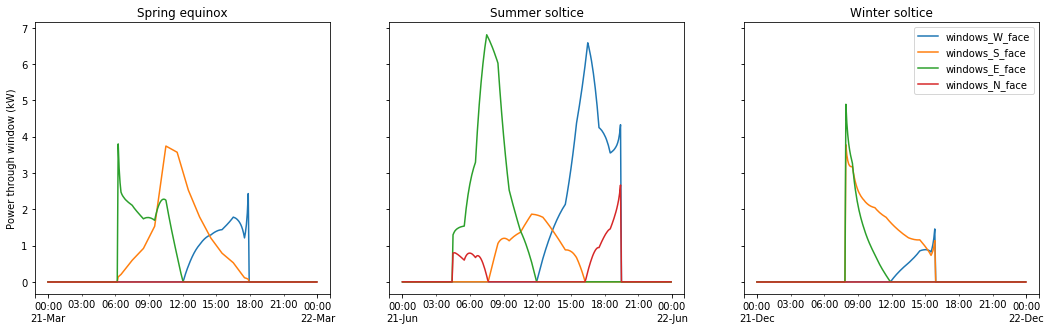

In [34]:
N_house.solar_plot('powers', ['windows_W_face', 'windows_S_face', 'windows_E_face', 'windows_N_face'], ymax = 22)
N_house.seasons_comparison_plot('powers')

The same picture seen with the weightings remains, if a little less cleanly. North facing windows only see the sun in the summer. More solar power passes through South facing windows in the winter than in the summer. West and East facing windows have the most solar power passing through them in spring and autumn.

Finally we need to integrate the powers with respect to time to get the energies. The plot below shows the solar energy entering the house through the windows on each face of a building each day. Again, the building in question has identical window areas on each side. 

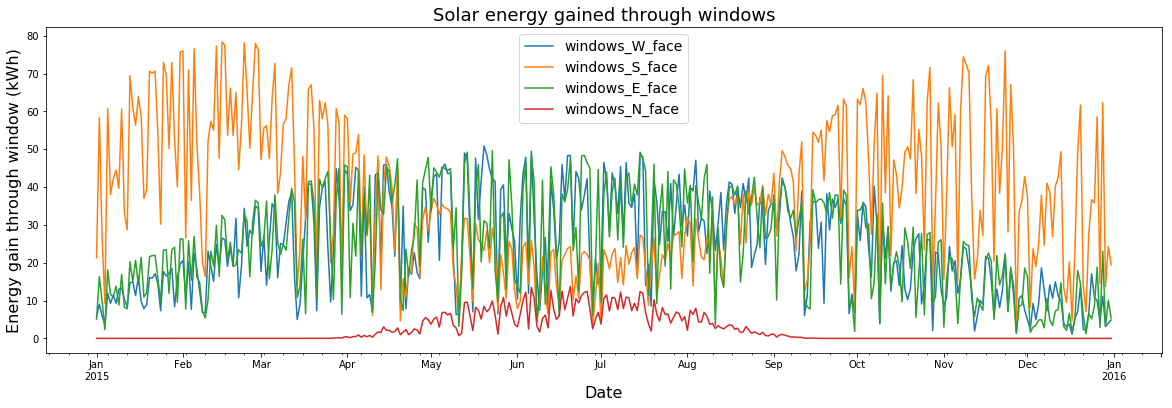

In [35]:
N_house.solar_plot('energy', ['windows_W_face', 'windows_S_face', 'windows_E_face', 'windows_N_face'])

 ## Implications for energy efficient buildings ##
 
 We now have a model capable of calculating the solar power and energy gains of houses with different orientations, window areas and windows. We can use that model to explore how how we can exploit those solar gains in building design. If you want to benefit from solar gains in the winter but not have a huge cooling load in summer then you want to maximise your solar gains in winter but minimise your solar gains in summer. There are 4 things we can change about a building to achieve this objective:
 
 1. Building orientation 
 2. Window areas and placement
 3. Window solar heat gain coefficient
 4. Shading
 
### Orientation ###
Lets start with building orientation. The figure above showed the daily solar energy gains of a house which is oriented N/S/E/W and has $8 m^2$ of windows on each face. Let's look at how those gains would change if we rotated that house by 45 degrees such that it was oriented NE/NW/SE/SW. The figure below shows the gains through the windows on each face of that house. The equivalent figure for the N/S/E/W is also reproduced below to make it easier to compare the two.

In [36]:
NW_windows = {'SW': (8, 0.4), 'SE': (8, 0.4), 'NW': (8, 0.4), 'NE': (8, 0.4)} 
NW_house = Solar_Gains(location, NW_windows, min_alt, path_unmodified)

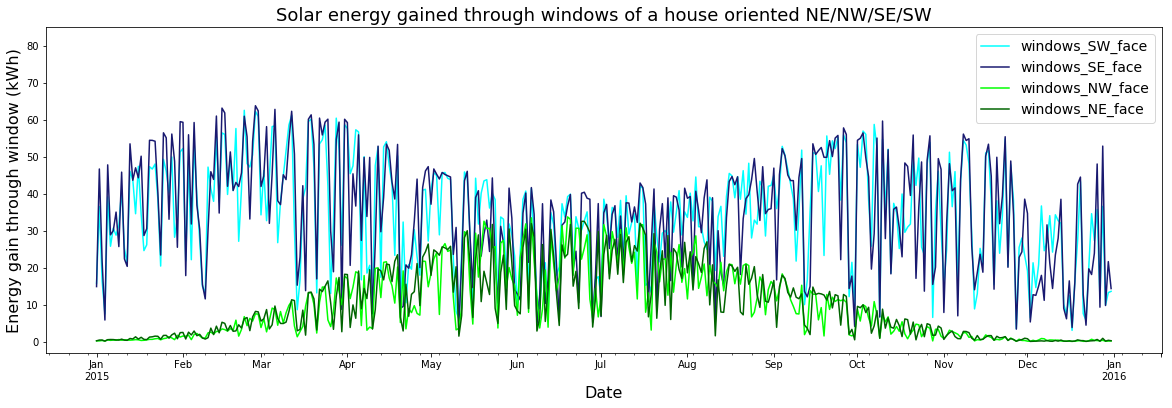

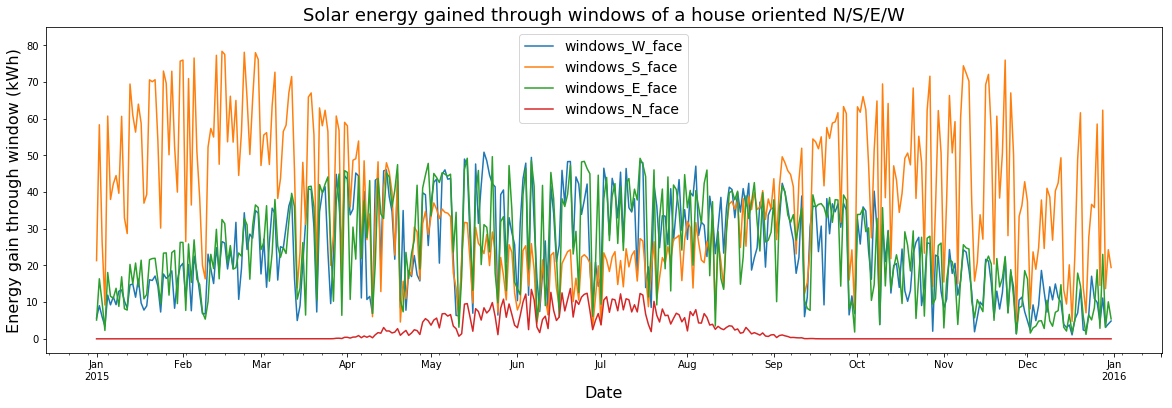

In [37]:
NW_house.solar_plot('energy', ['windows_SW_face', 'windows_SE_face', 'windows_NW_face', 'windows_NE_face'], ymax = 85, title = 'Solar energy gained through windows of a house oriented NE/NW/SE/SW')
N_house.solar_plot('energy', ['windows_W_face', 'windows_S_face', 'windows_E_face', 'windows_N_face'], ymax = 85, title = 'Solar energy gained through windows of a house oriented N/S/E/W')

Let's look first at the NE/NW/SE/SW house. The NE and NW faces give big gains in the summer and no gains at all in the winter. That means that NE/NW facing windows increase cooling loads but provide no heating - not a desireable profile. The South East and South West faces give the highest gains in the shoulder seasons. The gains in summer and winter are very similar to one another. The shoulder season gains come with the downside of quite big solar gains in summer and so a big extra cooling load. 

Now let's look at the N/S/E/W oriented house. East and West faces give low solar gains in the winter and high solar gains in summer. Again, this doesn't match well with our heating and cooling loads. The North face only gives solar gains in the summer, and even then they are pretty small. The South face gives big solar gains in the winter and small solar gains in the summer. That's exactly what we want. South facing windows allow the sun to heat the house a lot in winter while not adding too much to the cooling load in the summer. That profile cannot be recreated by combining the gains on other walls. So if we have the choice, we should always orient buildings so that they have a South facing wall.

### Where should I put my windows? ###

We now know the heating characteristics of windows in each orientation. We have seen that, given the choice, we would choose to orient buildings such that they have a South facing wall. So with our N/S/E/W house, let's see how we can change the window layout of a building to maximise our gains in winter and to minimise our gains in summer.

We want to move as much window area as possible to the South face of the house. However,for lighting reasons we probably can't have all the windows on one side of the house. We'll leave 3$m^2$ of windows the N, W and E faces of the building and put the remaining 23$m^2$ of windows on the South face. If we are designing a new house we are also free to choose what windows to install on each side of the house. The solar heat gain coeffiecient of windows varies a lot. You can get windows with a solar heat gain coefficient of 0.1 and others with a coefficient of 0.7. We can further improve the passive heating of our house if we choose to put windows with the high gains coefficient on the sides that get winter sun, and windows with low gains coefficients on the sides that get summer sun. So we'll put windows with a solar heat gain coefficient of 0.65 on the S facing windows and windows with a solar heat gain coefficent of 0.15 on the other faces.

The resultant gains are shown on the plot below. The gain through all of the windows in the house is plotted this time, because it is the total gain that affects our heating and cooling loads. The gain through all of the windows on the baseline house is also plotted. The baseline house is a house with the same orientation and total window area, but with the windows distributed equally on all sides of the house and with all windows having a solar heat gain coefficient of 0.3. 

In [38]:
N_windows_good_distribution = {'W': (3, 0.15), 'S': (23, 0.65), 'E': (3, 0.15), 'N': (3, 0.15)} 
N_house_good_window_distribution = Solar_Gains(location, N_windows_good_distribution, min_alt, path_unmodified)

In [39]:
def all_windows_comparison_plot(df1,df2, keys, title, colors, ymax):

    titlefontsize = 18
    axislabelfontsize = 16
    legendfontsize = 14

    df_plot = pd.concat([df1.energy['all_windows'], df2.energy['all_windows']], axis=1, keys = keys)
    ylab = 'Energy gain through window (kWh)'
    colors = colors
    df_plot.plot(figsize = (20,6), color = colors)
    plt.xlabel('Date', fontsize = axislabelfontsize)
    plt.ylabel(ylab, fontsize = axislabelfontsize)
    plt.ylim(ymax = ymax)
    plt.title(title, fontsize = titlefontsize)
    plt.legend(fontsize = legendfontsize)
    plt.show()

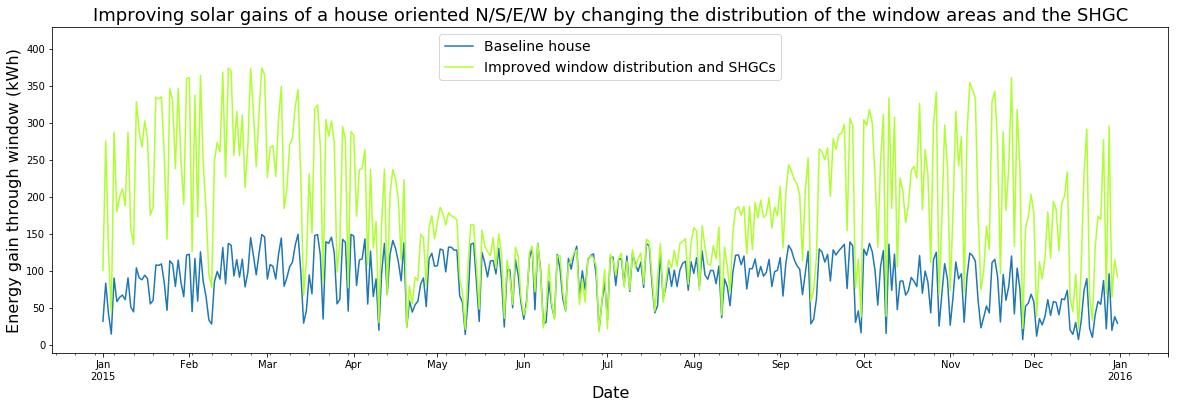

In [40]:
keys = ['Baseline house', 'Improved window distribution and SHGCs']
title_N = 'Improving solar gains of a house oriented N/S/E/W by changing the distribution of the window areas and the SHGC'
colors_N = ['#1f77b4', 'greenyellow'] 
ymax = 430
all_windows_comparison_plot(N_house,N_house_good_window_distribution, keys, title_N, colors_N, ymax)

Compared to the baseline house we have managed to increase the winter gains threefold without increasing the summer gains at all! 

A bit of context on what these energy values mean: A detached house with a floor area of 1600 square foot per floor might need 270 kWh of heating on the coldest day in winter, and 110kWh of cooling on the sunniest day in summer. In Quebec (where electricity is particularly cheap), a kWh costs between 6.8 and 10.5 ¢/kWh after tax (depending on how much you consume). So that 270kWh of heating on the coldest day would cost between \$18.36 and \$28.35 if provided by electric baseboards. 

When it isn't cloudy, the solar gains for this optimised house are at or above 270kWh per day for the whole heating period. So, provided that we can keep that heat in the house through the night (which is a challenge that we won't explore here), the house will only need heating on cloudy days. That's pretty astonishing. 

### Retrofit of existing buildings ###

Unless you are building a new house you can't do much about the orientation of your house. Changing where your windows are is also a pretty major retrofit. But changing the windows themselves is a much more achievable idea and something you will do at reasonably regular intervals. So if we return to our N/S/E/W house with 8m2 of windows on each side, how much can we do by just varying the SHGC? We'll install windows with a SHGC of 0.65 on the South face and a SHGC of 0.15 on the other sides. 

In [41]:
N_windows_good_shgc = {'W': (8, 0.15), 'S': (8, 0.65), 'E': (8, 0.15), 'N': (8, 0.15)} 
N_house_good_shgc = Solar_Gains(location, N_windows_good_shgc, min_alt, path_unmodified)

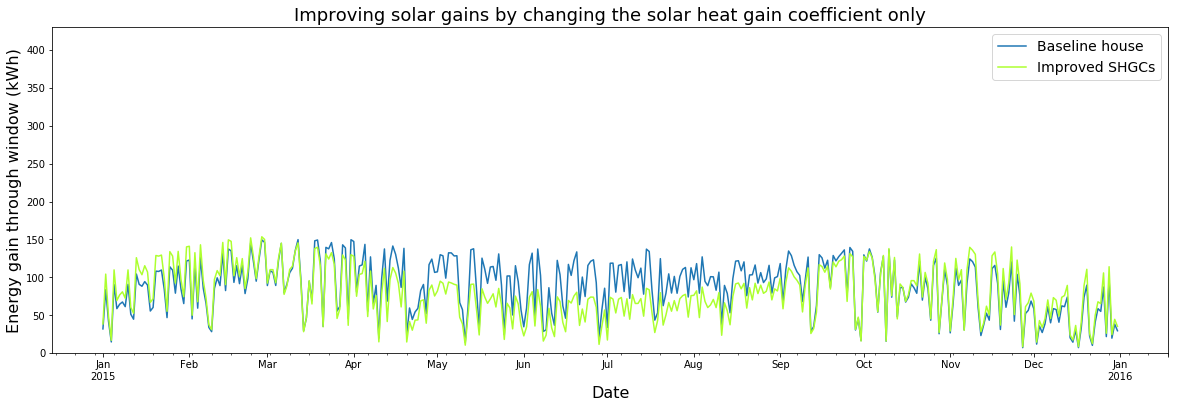

In [42]:
keys = ['Baseline house', 'Improved SHGCs']
title = 'Improving solar gains by changing the solar heat gain coefficient only'
colors = ['#1f77b4', 'greenyellow'] 
ymax = 430
all_windows_comparison_plot(N_house,N_house_good_shgc, keys, title, colors, ymax)

This is far less powerful than moving the windows but it is still helpful. In the winter the gains have only increased very slightly. However the summer gains are much reduced - going from around 125kWh/day on sunny days to around 75kWh/day on sunny days. As such the heating bill for the house would be slightly reduced but the cooling bill would be significantly reduced.

### The downside of windows ###

Windows are poor insulators compared to walls and so a lot of heat is lost through windows by conduction. If your windows are poorly positioned or have inefficient SHGC's, it's easy for your windows to *cost you more money* in heating than they save you. 

A typical, double glazed window with a plastic frame will have a conductivity of about 3 $W/m^2/C$. That means that, a window of 1 $m^2$ with a temperature difference of 1 degree C across it will be losing heat at a rate of 3W. If we have 32 $m^2$ of windows which have a conductivity of 3 W/m2/C then the house will lose 96 W per degree C of difference between the ouside and inside temperature. If it is -23 outside and 22 inside then you have a temperature difference of 45 degrees across the windows. That means you are going to be losing heat at a rate of 4.3kW through the windows. If we multiply that by 24 hours then we have lost 104 kWh of heat through those windows in one day (assuming it stayed -23 outside for the whole time). If we look back we can see that our 'new building' optimised designs were gaining much more than that 104kWh of energy from the sun on all but the cloudiest of days. In contrast, the solar energy gains for the baseline house were often below 104kWh in winter. Often on those days, more energy would be lost than gained through the windows. 

It is therefore really important to design windows carefully in new buildings. Windows can reduce our heating loads without increasing our cooling loads too much if we use them well, but they can increase our heating loads  and our cooling loads substantially if we design them badly. 

## Summing up ##

Some relatively simple geometry has allowed us to combine some individually uninteresting data sets to give some really useful results. The resulting model lets us calculate the solar power entering a house through its windows on an hourly basis, for any house orientation and any window layout. 

By exploring that model, we saw that window design can have a striking effect on the heating and cooling requirements of a building. In particular, we saw that window orientation is very important.

- South facing windows have an excellent solar gains profile. They give high solar gains in winter, reducing the need for other heating sources, and they give small solar gains in summer, minimising the need for cooling. 
- West and East facing windows on the other hand are best avoided. They give big solar gains in summer when you don't want them, and small solar gains in winter when you do. 
- North facing windows only give any solar gains in the summer, and even then, the solar gains are small. 

Passive solar building design can utilise these insights. You can design buildings with a big South facing wall and then maximise window areas on that South face. You can adjust the solar heat gain coefficient of windows on different faces as function of how good the profile of solar gains through those windows is. You can also shade South faces to prevent the high summer sun from entering the room at all. 

Marmott Energies does not work in passive solar design, but we are excited about all technologies which can have a meaningful impact on the carbon footprint of buildings. We built this model of solar gains because it lets us size goethermal systems properly. When we size geothermal systems, we combine this solar gains model with a model of the other heat gains and losses of a house. The combined model gives us the energy needed to heat and cool the house for every hour of a typical year. With that model we can size a geothermal system that will provide the lions share of the heating, but that won't have expensive excess capacity that is only used a few days a year. This model therefore lets us design geothermal systems that give a great return on investment, thus making geothermal affordable and accesible. 
